# **`word2vec` Training Workflow (Davies Corpora)**
In this workflow, we train `word2vec` models across years from Davies corpora (e.g., COHA, COCA). Unlike Google Books ngrams which store pre-computed n-grams, Davies corpora store full sentences from which we can train word2vec models directly. 

We first train models using a range of hyperparameters (e.g., vector dimensions and training epochs). The purpose is twofold: (1) to determine whether models from earlier years are reasonably stable, and (2) choose a set of hyperparameters that yield good results across all years. Models are evaluated using "intrinsic" tests of similarity and analogy performance, which we visualize using plots and analyze using linear regression.

Once we've chosen our hyperparameters, we use them to train models for all available years in the corpus.

## **Setup**
### Imports

In [14]:
%load_ext autoreload
%autoreload 2

from ngramkit.ngram_train.word2vec import (
    train_models,
    transfer_models
)
import shutil
from pathlib import Path
from ngramkit.ngram_train.word2vec.evaluate import evaluate_models
from ngramkit.ngram_train.word2vec.visualize import plot_evaluation_results
from ngramkit.ngram_train.word2vec.regression_analysis import run_regression_analysis, plot_regression_results
from ngramkit.ngram_train.word2vec.normalize_and_align_models import normalize_and_align_vectors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configure
Here we set basic parameters: the corpus name, database path, and any corpus-specific settings.

In [12]:
corpus_name = 'COHA'
corpus_path = f'/scratch/edk202/NLP_corpora/{corpus_name}'
model_dir = corpus_path.replace('NLP_corpora', 'NLP_models')

## **Test Model Hyperparameters**
### Train Models
Here we test models across available years, cycling through a range of reasonable hyperparameters. For Davies corpora like COHA, we constrain our grid search as follows:
1. We stick to the Skip-Gram (`skip-gram`) approach. Skip-gram generally performs well for semantic similarity tasks.
2. We test vector dimensions (`vector_size`) from 100 to 300. Our vocabulary size supports meaningful feature extraction in this range.
3. We test training epochs (`epochs`) from 10 to 30. More than 30 epochs risks overfitting.
4. We set the minimum word count (`min_count`) to 1, meaning that no words will be excluded from training. Our whitelist filtering ensures that all vocabulary words appear with sufficient frequency.
5. Weighting (`weight_by`) is set to none. `word2vec` already implements frequency-based downweighting.
6. We use a context window (`window`) appropriate for the full sentence context available in Davies corpora.

In [5]:
train_models(
    corpus_path=corpus_path,
    years=(1900, 2000),
    year_step=10,
    dir_suffix='test',
    weight_by=('none',),
    vector_size=(100, 200, 300),
    window=(10,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(10, 20, 30),
    max_parallel_models=32,
    workers_per_model=4,
    mode="restart",
    unk_mode="retain",
    use_corpus_file=True,
    cache_corpus=True
);



WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-12-15 22:32:10

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             /scratch/edk202/NLP_corpora/COHA/COHA_filtered
Model directory:      /scratch/edk202/NLP_models/COHA/models_test
Log directory:        /scratch/edk202/NLP_models/COHA/logs_test/training
Parallel models:      32

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2000 (step=10, 11 years)
Weighting:            ('none',)
Vector size:          (100, 200, 300)
Context window:       (10,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training epochs:      (10, 20, 30)

Data Options
────────────────────────────────────────────────────────────────────────────────────────────────────
UNK mo

Training Models: 100%|██████████| 99/99 [59:23<00:00, 35.99s/ models]  


Training Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models trained:       99
Model directory:      /scratch/edk202/NLP_models/COHA/models_test
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



### Evaluate Models

Here we evaluate the models we've trained using two "intrinsic" tests: (1) a _similarity test_ assessing how well each model predicts human-rated synonymy judgments, and (2) an _analogy test_ assessing how well each model can answer SAT-style analogy questions. Test results are saved to a CSV file.

Similarity performance is the metric of choice for models intended to track semantic relatedness over time. However, we run both tests here to demonstrate the evaluation code and show that different hyperparameters lend themselves to different performance metrics.

In [ ]:
evaluate_models(
    model_dir=model_dir,
    dir_suffix='test',
    eval_dir=model_dir,
    save_mode='overwrite',
    run_similarity=True,
    run_analogy=True,
    workers=128
);


WORD2VEC MODEL EVALUATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-12-15 23:34:03

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Model directory:      /scratch/edk202/NLP_models/COHA/models_test
Evaluation file:      /scratch/edk202/NLP_models/COHA/evaluation_results_test.csv
Log directory:        /scratch/edk202/NLP_models/COHA/logs_test/evaluation
Save mode:            overwrite

Evaluation Datasets
────────────────────────────────────────────────────────────────────────────────────────────────────
Similarity dataset:   ...miniforge/lib/python3.11/site-packages/gensim/test/test_data/wordsim353.tsv
Analogy dataset:      ...orge/lib/python3.11/site-packages/gensim/test/test_data/questions-words.txt

Found 99 models to evaluate



Evaluating models:   0%|          | 0/99 [00:00<?, ? models/s]

### Visualize Model Performance
The code below plots the results of the similarity and analogy tests for easy inspection.
#### Similarity Results

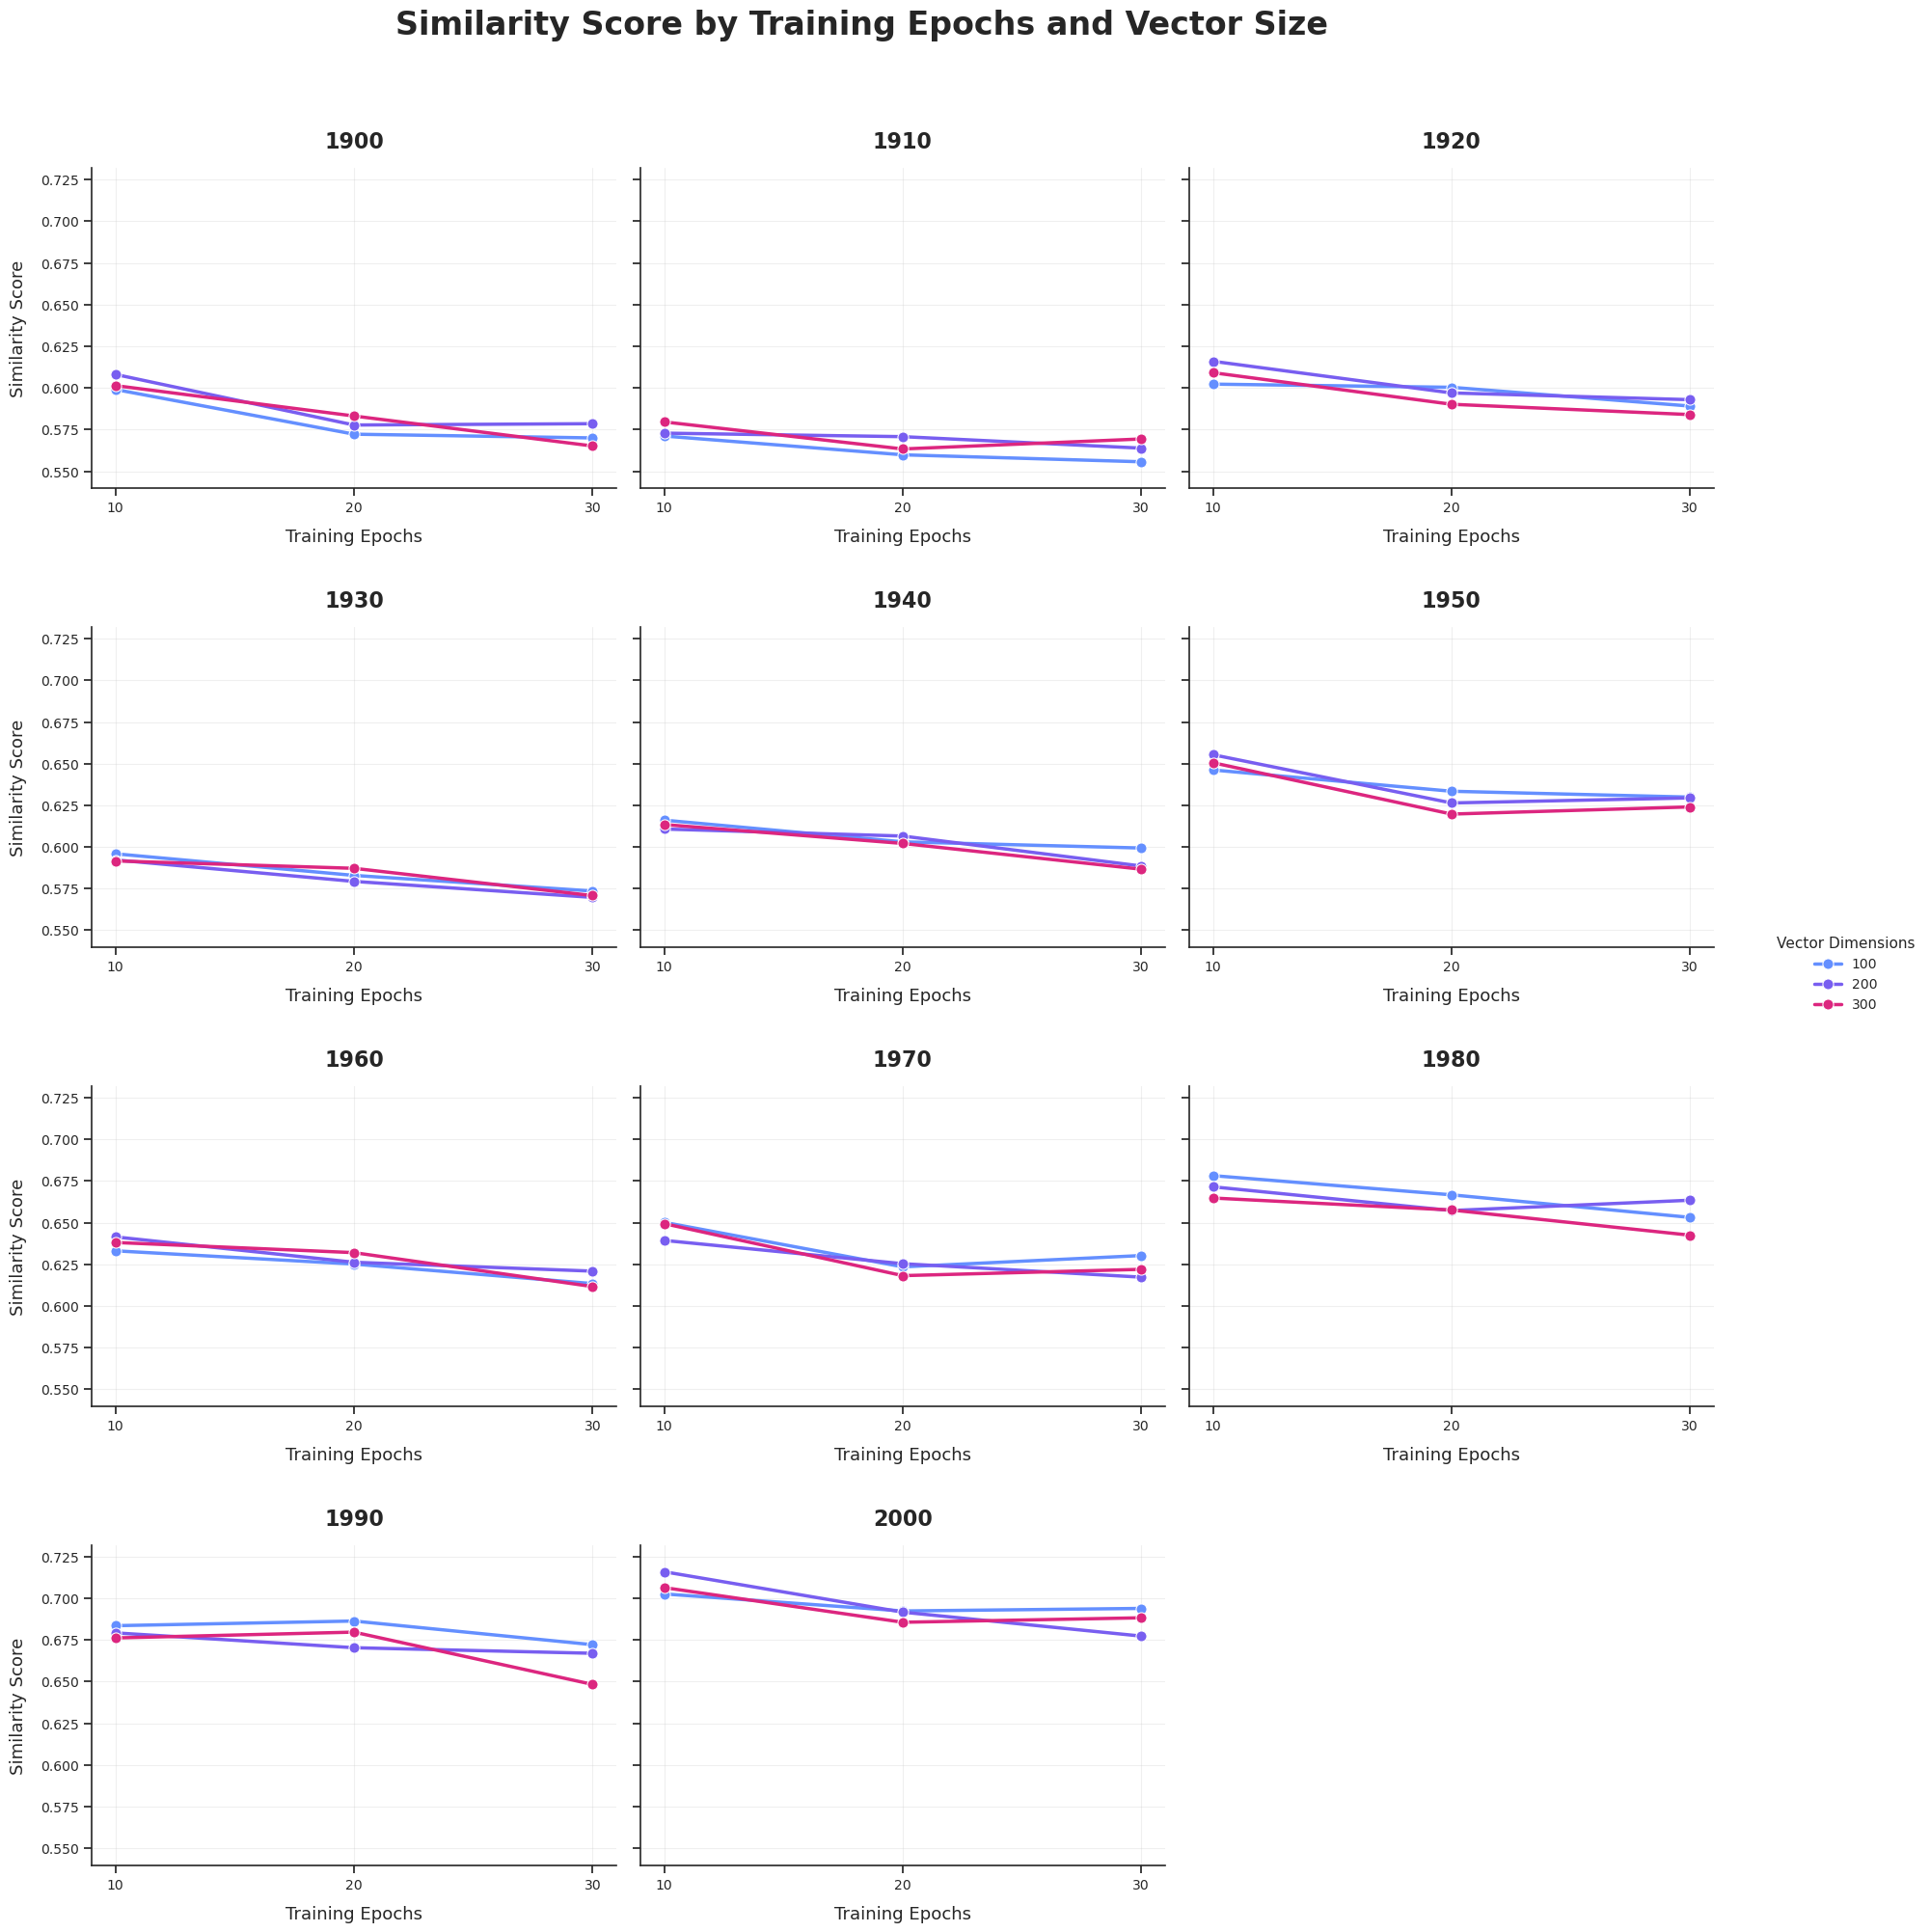

In [4]:
csv_file = f'{model_dir}/evaluation_results_test.csv'

plot_evaluation_results(
    csv_file=csv_file,
    verbose=False,
    metric='similarity_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Similarity Score by Training Epochs and Vector Size'
)

#### Analogy Results

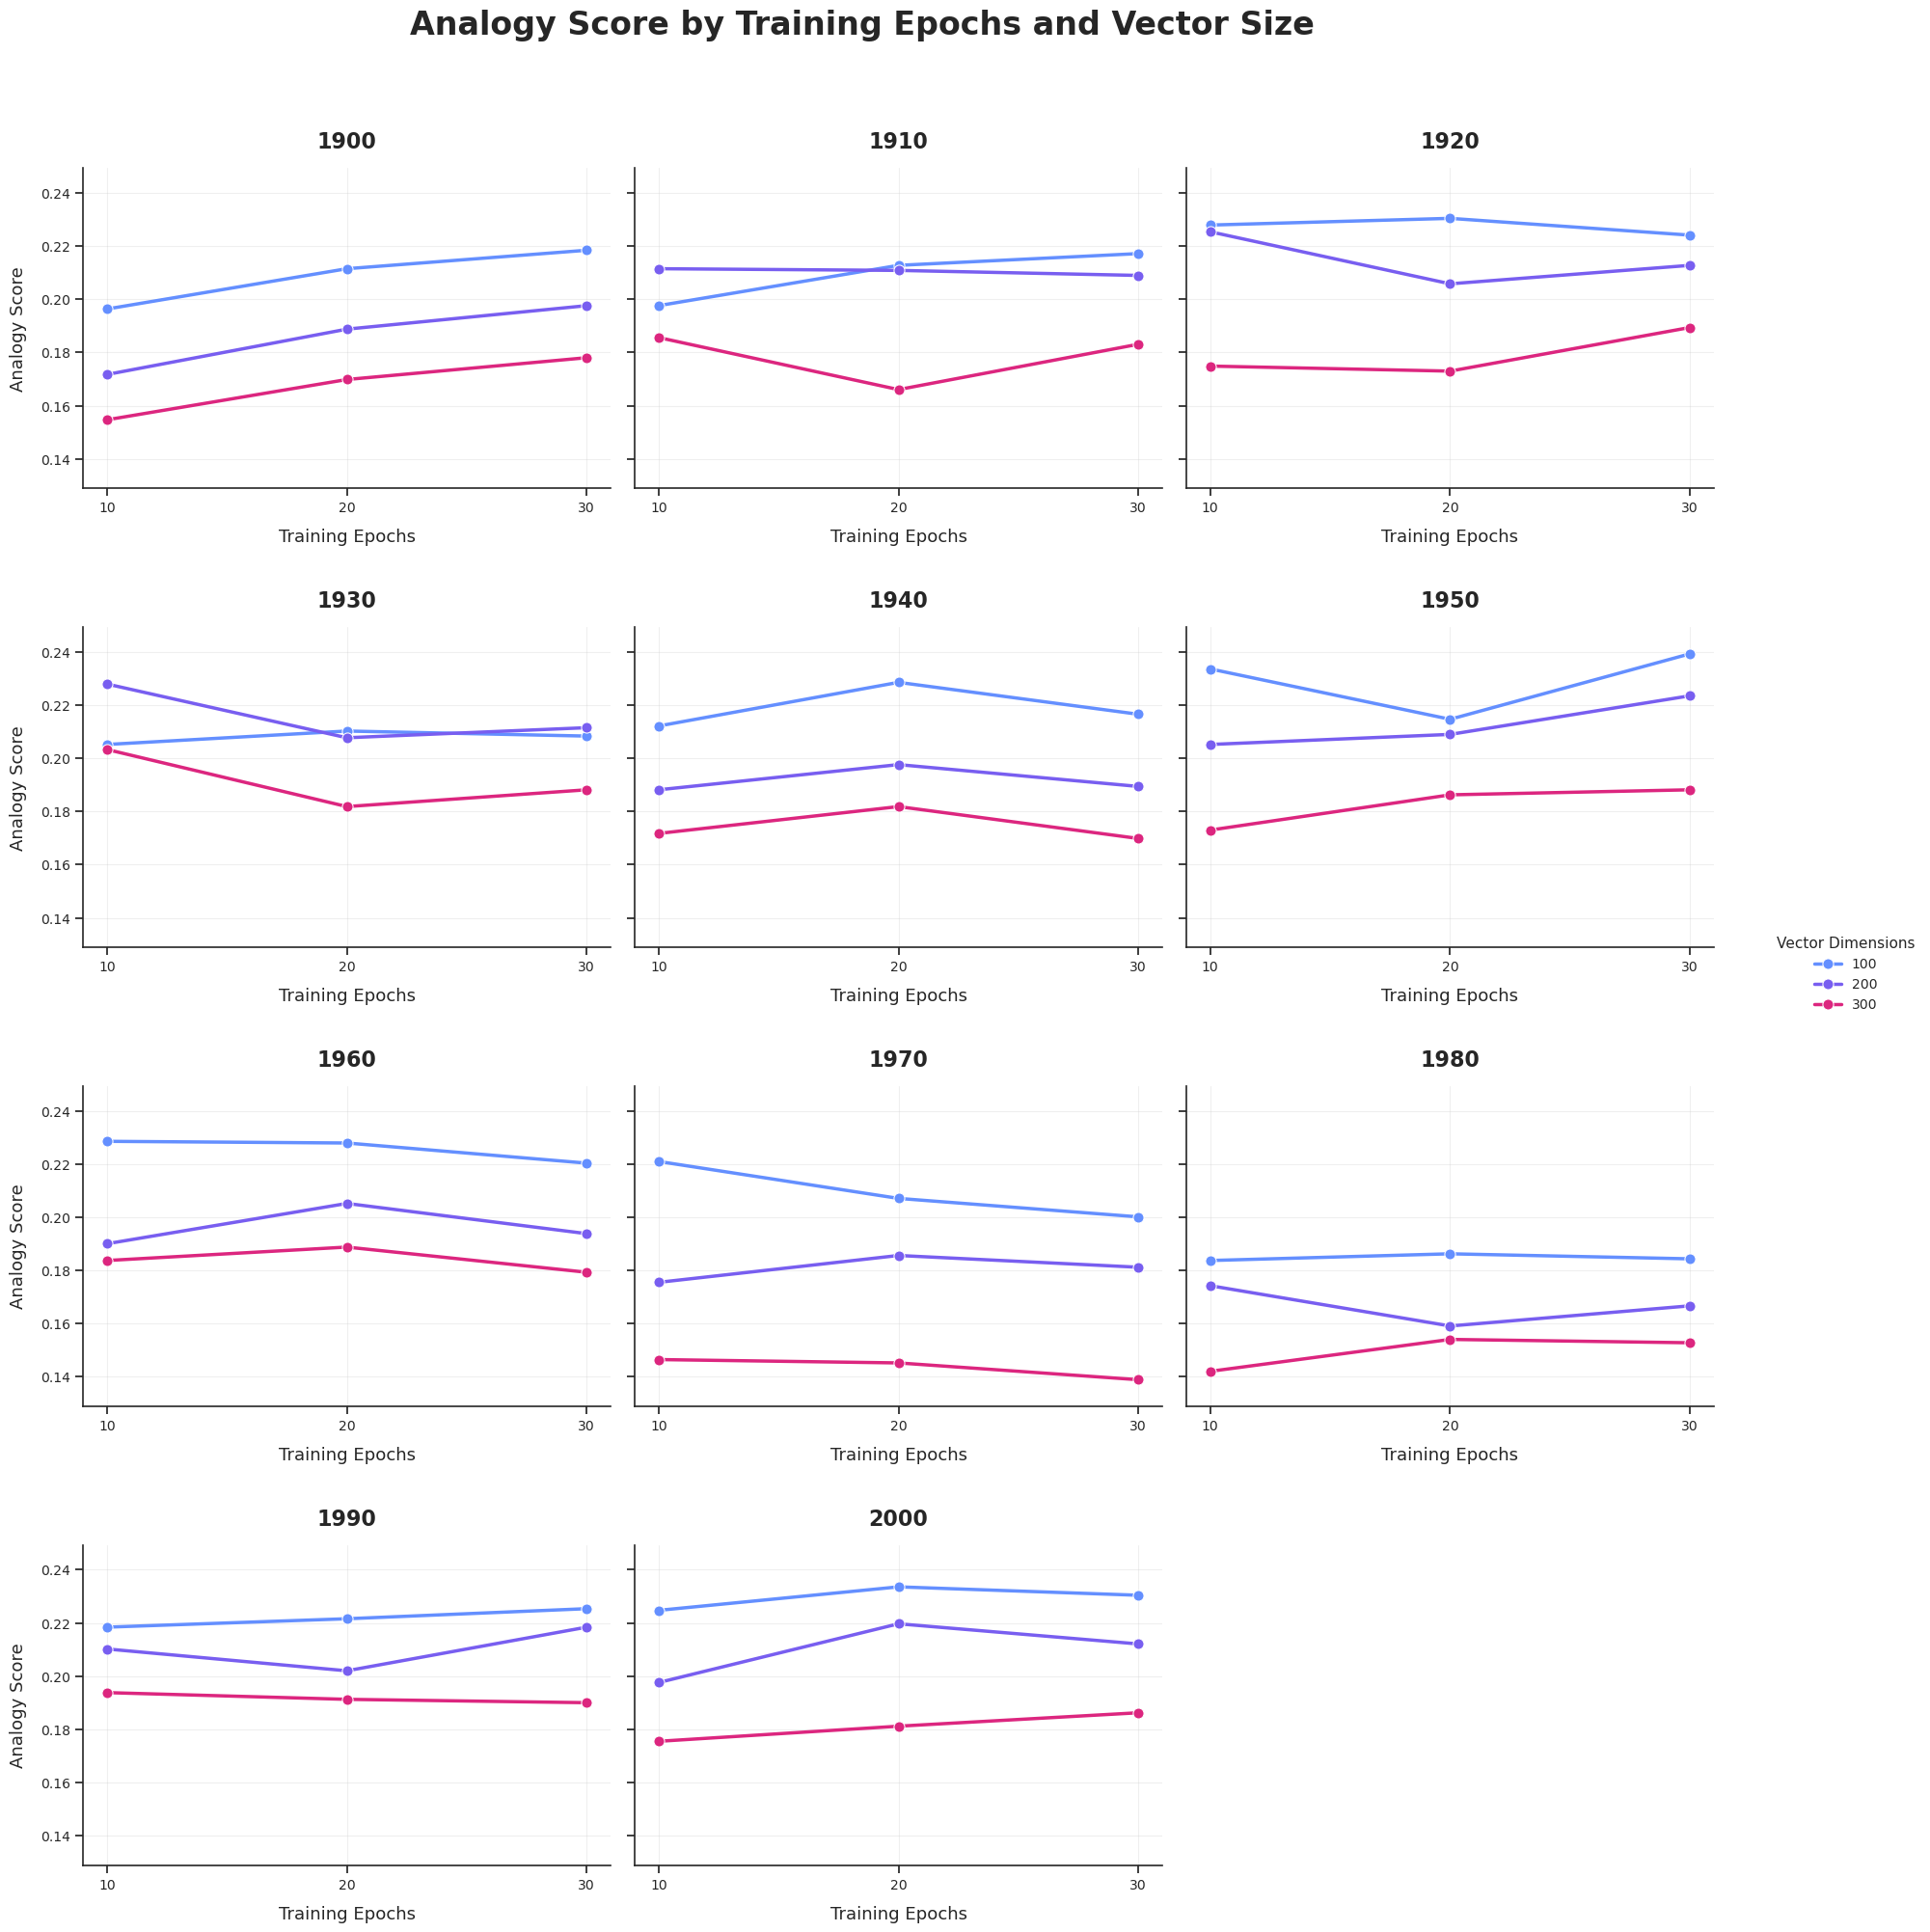

In [5]:
plot_evaluation_results(
    csv_file=csv_file,
    verbose=False,
    metric='analogy_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Analogy Score by Training Epochs and Vector Size'
)

### Regression Analysis
The code below runs regression analyses on the similarity and analogy results.
#### Predictors of Similarity Performance

Loading data...
Loaded 99 observations
Number of years: 11

Model specification:
  Formula: similarity_score ~ scale(year) + scale(vector_size) + scale(epochs) + scale(year):scale(vector_size) + scale(year):scale(epochs) + scale(vector_size):scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Model converged successfully!

                   Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     similarity_score
No. Observations:       99          Method:                 REML            
No. Groups:             11          Scale:                  0.0000          
Min. group size:        9           Log-Likelihood:         303.4504        
Max. group size:        9           Converged:              Yes             
Mean group size:        9.0                                                 
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z|

/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


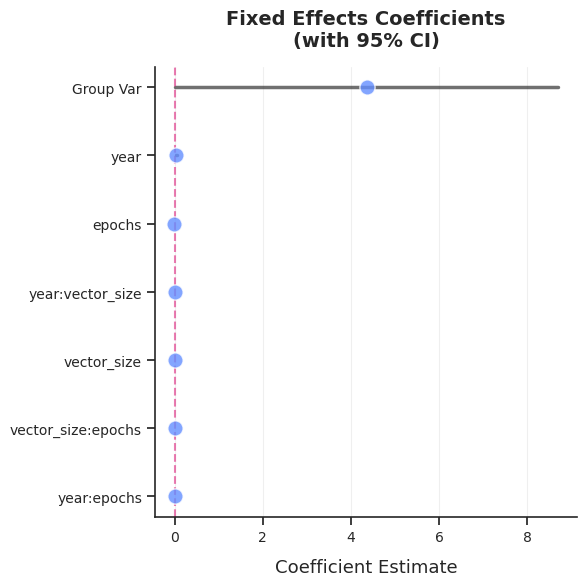

In [6]:
results = run_regression_analysis(
    csv_file=csv_file,
    model_type="auto",
    outcome='similarity_score',
    predictors=['year', 'vector_size', 'epochs'],
    interactions=[('year', 'vector_size'), ('year', 'epochs'), ('vector_size', 'epochs')],
)

plot_regression_results(results)

#### Predictors of Analogy Performance

Loading data...
Loaded 99 observations
Number of years: 11

Model specification:
  Formula: analogy_score ~ scale(year) + scale(vector_size) + scale(epochs) + scale(year):scale(vector_size) + scale(year):scale(epochs) + scale(vector_size):scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Model converged successfully!

                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      analogy_score
No. Observations:        99           Method:                  REML         
No. Groups:              11           Scale:                   0.0001       
Min. group size:         9            Log-Likelihood:          264.5270     
Max. group size:         9            Converged:               Yes          
Mean group size:         9.0                                                
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0

/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


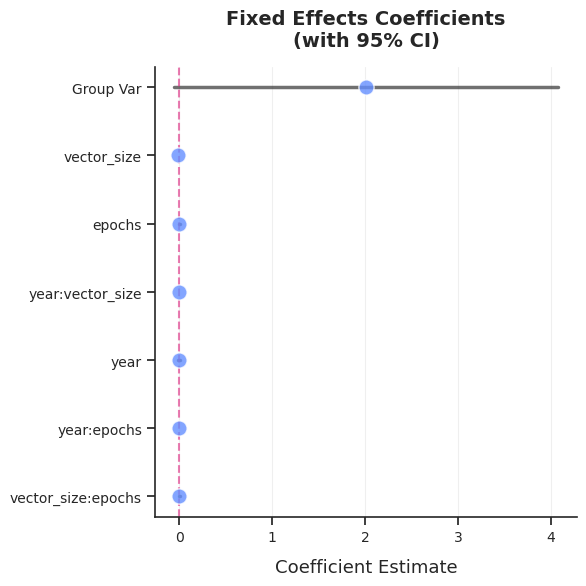

In [7]:
results = run_regression_analysis(
    csv_file=csv_file,
    model_type="auto",
    outcome='analogy_score',
    predictors=['year', 'vector_size', 'epochs'],
    interactions=[('year', 'vector_size'), ('year', 'epochs'), ('vector_size', 'epochs')],
)

plot_regression_results(results)

## **Transfer or Train Final Models**

We have two options now that the hyperparameter search is complete. If the desired final models are in the search set, we can simply transfer them to a new directory for analysis. Or, if the desired models aren't in the test set, we can train the final models and place them in the analysis directory.

### Transfer Final Models

In [8]:
source_dir = Path(f'{model_dir}/models_test')
dest_dir = Path(f'{model_dir}/models_final')

if dest_dir.exists():
    shutil.rmtree(dest_dir)
dest_dir.mkdir(parents=True)

transferred = 0
for model_file in source_dir.glob('*.kv'):
    if 'vs100' in model_file.name and 'e010' in model_file.name:
        shutil.copy2(model_file, dest_dir / model_file.name)
        transferred += 1

print(f"Transferred {transferred} models from {source_dir} to {dest_dir}")

Transferred 11 models from /scratch/edk202/NLP_models/COHA/models_test to /scratch/edk202/NLP_models/COHA/models_final


### Train Final Models

In [ ]:
train_models(
    corpus_path=corpus_path,
    years=(1900, 2000),
    year_step=10,
    dir_suffix='final',
    weight_by=('none',),
    vector_size=(200,),
    window=(10,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(10,),
    max_parallel_models=50,
    workers_per_model=2,
    mode="resume",
    unk_mode="retain",
    use_corpus_file=True
);

## **Normalize and Align Models**

Before we can use the models for diachronic analysis, we need to unit-normalize the vectors and align them across years using Procrustes rotation. The `normalize_and_align_vectors` function does this.

In [15]:
print(proj_dir)

/scratch/edk202/NLP_models/COHA


In [17]:
proj_dir = model_dir
dir_suffix = 'final'
anchor_year = 2000
workers = 50

normalize_and_align_vectors(
    ngram_size=None,
    proj_dir=proj_dir,
    dir_suffix=dir_suffix,
    anchor_year=anchor_year,
    workers=workers
)

Saved normalized anchor model to /scratch/edk202/NLP_models/COHA/models_final/norm_and_align/w2v_y2000_wbnone_vs100_w010_mc001_sg1_e010.kv


Processing models: 100%|██████████| 10/10 [00:02<00:00,  3.82file/s]

Total runtime: 0:00:03.138894
Processed 11 models. Aligned to anchor year 2000.
